In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import optimize
import os
import multiprocessing as mp

plt.style.use('seaborn')

In [2]:
# Creates a "particle tree" which is a dictionary containing
# { event0 : {ptcls} , event1 : {ptcls} , ... }
# "ptcls" contains:
# { ptclID : { "allEvents" : [] , "children" : {ptcls} } }
# where "allEvents" is every event performed by the particle with ID == ptclID
# and "children" recursively stores "ptcls" structures for each child

def buildPtclTree(filePath):
    ptclTree = {}
    
    data = np.array(pd.read_csv(filePath))
    
    IDtoRow = {}
    for row in data:
        IDtoRow[row[0]] = row

    for row in data:
        skipRow = False
        
        # Stack of parents
        IDStack = []
        ID = row[0]
        while "-0" not in ID:
            IDStack.append(ID)
            if ID not in IDtoRow:
                skipRow = True
                break
            ID = IDtoRow[ID][1]
            
        if skipRow :
            continue

        ID = 0
        currTree = ptclTree
        while True:
            ID = IDStack.pop()
            if ID not in currTree:
                currTree[ID] = { "allEvents" : [] , "children" : {} }

            if len(IDStack) == 0:
                currTree = currTree[ID]
                break

            currTree = currTree[ID]["children"]

        currTree["allEvents"].append(row)
        
    return ptclTree



In [107]:
# Takes in a "ptcl" and a material name, and finds the total energy deposited 
# by this particle, and all of its children, into that material

def netEDep(ptclInTree, materialName):
    eDep = 0
    for event in ptclInTree["allEvents"]:
        if event[4] in materialName:
            eDep += event[3]
    for child in ptclInTree["children"].values():
        eDep += netEDep(child, materialName)
    ptclInTree["totalEDep"] = eDep
    return eDep

# Takes in a "ptcl" and a particle type, and if this particle or any of its
# children have that type

def hasNoChildrenOfType(ptclInTree, ptclType):
    hasChild = True
    
    if ptclInTree["allEvents"][0][2] in ptclType:
        return False
    
    for child in ptclInTree["children"].values():
        hasChild = hasChild and hasNoChildrenOfType(child, ptclType)
    
    return hasChild

# Prints a particle

def printPtcl(ptcl, indent = ">"):
    print("\n", indent , "Particle : " , ptcl["allEvents"][0][2] , " Energy : " , (ptcl["allEvents"][0][3] + ptcl["allEvents"][0][5]) / 1e3 , " keV ")
    for child in ptcl["children"].values():
        printPtcl(child, "---" + indent)
        
# Takes in a particle and finds the light generated in the scintillator 
# by the particle, or any of its children. 
# -> pRF is the "proton response function" which takes total energy deposited by a proton and 

def ptclLightYield(ptcl, pRF, cRF):
    pEDep = 0
    cEDep = 0
    
    for event in ptcl["allEvents"]:
        ptclType = event[2]
        if ptclType not in "proton C12 C13":
            break
        if event[4] not in "ej309":
            continue
        if ptclType in "proton":
            pEDep += event[3]
        if ptclType in "C12 C13":
            cEDep += event[3]
        
    
    lightYield = float( pRF( pEDep / 1e6 ) + cRF( cEDep / 1e6 ) )
    for child in ptcl["children"].values():
        lightYield += ptclLightYield(child, pRF, cRF)
    
    return lightYield



In [132]:
def f(x, A, B, C, D):
    return A*(x) + B*(x**2) + C*(x**3) + D*(x**4)



No handles with labels found to put in legend.


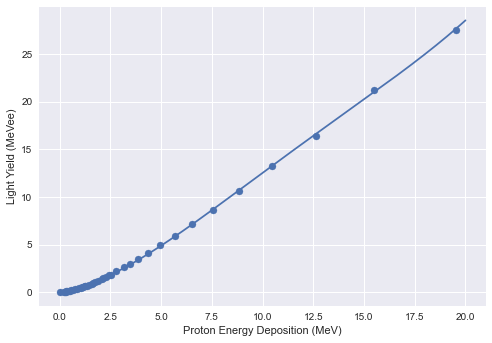

In [165]:
protonLightYield = np.array(pd.read_csv("ProtonResponseEJ309.txt", delimiter=' ', header = None))
xP = np.append(np.array([0]), protonLightYield[:,0])
yP = np.append(np.array([0]), protonLightYield[:,1])

plt.scatter(xP, yP)

poptP, pcovP = optimize.curve_fit(f, xP, yP)

x = np.linspace(0,20,100000)
#plt.plot(x, f(x, *poptP), label = "taylor series")

plt.xlabel("Proton Energy Deposition (MeV)")
plt.ylabel("Light Yield (MeVee)")
plt.legend()

pRF = lambda x: f(x, *poptP)

#pRF = interpolate.interp1d(xP, yP, kind = 'quadratic', fill_value='extrapolate')

plt.plot(x, pRF(x), label = "taylor series")

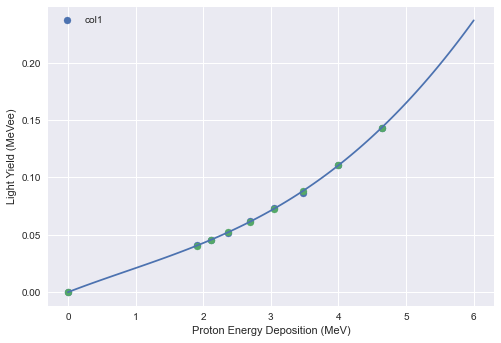

In [134]:
carbonLightYield = np.array(pd.read_csv("CarbonResponseEJ309.txt", delimiter=' ', header = None))
xC = np.append(np.array([0]), carbonLightYield[:,0])
yC = np.append(np.array([0]), carbonLightYield[:,1])

plt.scatter(xC, yC, label="col1")

poptC, pcovC = optimize.curve_fit(f, xC, yC)

plt.scatter(xC, f(xC, *poptC))
x = np.linspace(0,6,100)
plt.plot(x, f(x, *poptC))

plt.xlabel("Proton Energy Deposition (MeV)")
plt.ylabel("Light Yield (MeVee)")
plt.legend()

cRF = lambda x : f(x, *poptC)

In [29]:
pRF(0.772)

0.3741636453244641

In [87]:
def GetLightYield(data):
    
    ptclTree = buildPtclTree("../../EJ309-build/data/" + data)
    
    IDtoLightYield = []
    for ID in ptclTree:
        lightYield = ptclLightYield(ptclTree[ID], pRF, cRF)
        if lightYield > 0.0:
            IDtoLightYield.append(lightYield)
            
    return np.array(IDtoLightYield)


In [63]:
dataToLightYield = { }

for filename in os.listdir("../../EJ309-build/data/"):
    if filename.endswith(".csv"):
        dataToLightYield[filename] = GetLightYield(filename)

KeyboardInterrupt: 

Text(0, 0.5, 'counts')

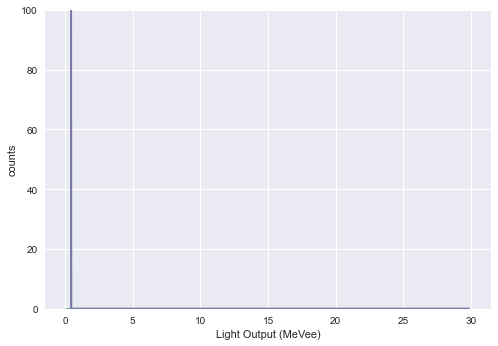

In [15]:
BINS = np.linspace(1e-3, 30, 101)
bins = np.zeros(len(BINS) - 1)
for i in range(0, len(BINS) - 1):
    bins[i] = (BINS[i + 1] + BINS[i]) / 2.0

for key in dataToLightYield:

    value = dataToLightYield[key]

    i = key.find("_")
    ptcl = key[0:i]
    key = key[i + 1:]

    i = key.find("_")
    energy = key[0:i]
    key = key[i + 1:]

    i = key.find(".")
    unit = key[0:i]

    ptcl, energy, unit
    dat = plt.hist(value, bins = BINS, alpha = 0)[0]
    plt.plot(bins, dat)
    plt.ylim(0,100)
    
plt.xlabel("Light Output (MeVee)")
plt.ylabel("counts")

In [69]:
lightYield = GetLightYield("neutron_20000_keV.csv")
bins = plt.hist(lightYield, bins = 800, range = (0.001, 10.001), density = True)
plt.xlabel("MeVee")

FileNotFoundError: [Errno 2] File ../../EJ309-build/data/neutron_20000_keV.csv does not exist: '../../EJ309-build/data/neutron_20000_keV.csv'

In [17]:
import pickle

In [88]:
ptcl = "neutron"
energy = "2.45"
unit = "MeV"

ptclTree1 = buildPtclTree("../../EJ309-build/data/"+ptcl+"_"+energy+"_"+unit+".csv")



KeyboardInterrupt: 

In [ ]:
plt.hist(dataToLightYield["neutron_"])

For the types of scattering plot

In [150]:
ptcl = "neutron"
energy = "2.45"
unit = "MeV"

ptclTree = buildPtclTree("../../EJ309-build/data/"+ptcl+"_"+energy+"_"+unit+".csv")

In [151]:
# Separate the data into categories : 
# single np , nCp, double np, triple np, other

scatterTypes = { "single_np" : [] , "nCp" : [] , "double_np" : [] ,
                 "triple_np" : [] , "other" : [] }

for ptcl in ptclTree.values() :
    # Put children in list
    children = list(ptcl["children"].values())
    # Sort by time of creation of child
    children.sort(key = lambda x : x["allEvents"][0][6])
    
    if len(children) == 1 and children[0]["allEvents"][0][2] in "proton":
        scatterTypes["single_np"].append(ptcl)
    elif len(children) > 1 and children[0]["allEvents"][0][2] in "proton" and children[1]["allEvents"][0][2] not in "proton":
        scatterTypes["single_np"].append(ptcl)
        
    elif len(children) == 2 and np.all([ c["allEvents"][0][2] in "proton" for c in children[:2] ]):
        scatterTypes["double_np"].append(ptcl)
    elif len(children) > 2 and np.all([ c["allEvents"][0][2] in "proton" for c in children[:2] ]) and children[2]["allEvents"][0][2] not in "proton":
        scatterTypes["double_np"].append(ptcl)
        
    elif len(children) == 3 and np.all([ c["allEvents"][0][2] in "proton" for c in children[:3] ]):
        scatterTypes["triple_np"].append(ptcl)
    elif len(children) > 3 and np.all([ c["allEvents"][0][2] in "proton" for c in children[:3] ]) and children[3]["allEvents"][0][2] not in "proton":
        scatterTypes["triple_np"].append(ptcl)
    
    elif len(children) == 2 and children[0]["allEvents"][0][2] in "proton" and children[1]["allEvents"][0][2] in "C12 C13":
        scatterTypes["nCp"].append(ptcl)
    elif len(children) == 2 and children[1]["allEvents"][0][2] in "proton" and children[0]["allEvents"][0][2] in "C12 C13":
        scatterTypes["nCp"].append(ptcl)
        
    else:
        scatterTypes["other"].append(ptcl)
    

In [152]:
singleNP = np.array([ptclLightYield(ptcl, pRF, cRF) for ptcl in scatterTypes["single_np"]])
doubleNP = np.array([ptclLightYield(ptcl, pRF, cRF) for ptcl in scatterTypes["double_np"]])
tripleNP = np.array([ptclLightYield(ptcl, pRF, cRF) for ptcl in scatterTypes["triple_np"]])
nCp = np.array([ptclLightYield(ptcl, pRF, cRF) for ptcl in scatterTypes["nCp"]])
other = np.array([ptclLightYield(ptcl, pRF, cRF) for ptcl in scatterTypes["other"]])
total = np.concatenate((singleNP,doubleNP,tripleNP,nCp,other))

Text(0.5, 1.0, 'EJ309 Light Yield from 2.45 MeV Neutron Source')

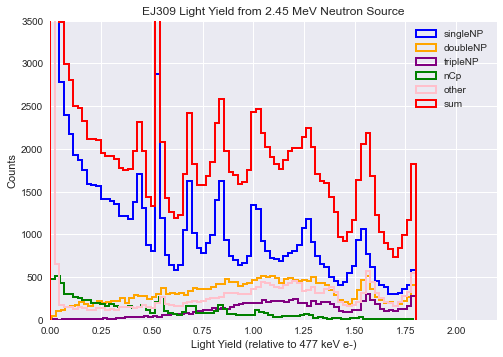

In [153]:
data = singleNP
colors = "blue"
labels = 'singleNP'
plt.hist(data, histtype = "step", color = colors, label=labels, bins = 80, linewidth = 2)

data = doubleNP
colors = "orange"
labels = 'doubleNP'
plt.hist(data, histtype = "step", color = colors, label=labels, bins = 80, linewidth = 2)

data = tripleNP
colors = "purple"
labels = 'tripleNP'
plt.hist(data, histtype = "step", color = colors, label=labels, bins = 80, linewidth = 2)

data = nCp
colors = "green"
labels = 'nCp'
plt.hist(data, histtype = "step", color = colors, label=labels, bins = 80, linewidth = 2)

data = other
colors = "pink"
labels = 'other'
plt.hist(data, histtype = "step", color = colors, label=labels, bins = 80, linewidth = 2)

plt.hist(total, histtype = "step", bins = 80, linewidth = 2, label="sum", color="red")

plt.legend()
plt.xlim(0,2.2)
plt.ylim(0,3500)
plt.ylabel("Counts")
plt.xlabel("Light Yield (relative to 477 keV e-)")
plt.title("EJ309 Light Yield from 2.45 MeV Neutron Source")